In [56]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from bs4 import BeautifulSoup
import unicodedata
#import contractions
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [57]:
data = pd.read_csv("reviews.csv")

In [58]:
def strip_html_tag(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [59]:
# remove accented characters
def strip_accents(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [60]:
# remove special characters
def strip_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

In [61]:
CONTRACTION_MAP = {"ain't": "is not","aren't": "are not", "can't": "cannot", "can't've": "cannot have",
                   "'cause": "because", "dr" : "doctor",
                   "could've": "could have",
                   "couldn't": "could not",
                   "couldn't've": "could not have",
                   "didn't": "did not",
                   "doesn't": "does not",
                   "don't": "do not",
                   "hadn't": "had not",
                   "hadn't've": "had not have",
                   "hasn't": "has not",
                   "haven't": "have not",
                   "he'd": "he would",
                   "he'd've": "he would have",
                   "he'll": "he will",
                   "he'll've": "he will have",
                   "he's": "he is",
                   "how'd": "how did",
                   "how'd'y": "how do you",
                   "how'll": "how will",
                   "how's": "how is",
                   "I'd": "I would",
                   "I'd've": "I would have",
                   "I'll": "I will",
                   "I'll've": "I will have",
                   "I'm": "I am",
                   "I've": "I have",
                   "i'd": "i would",
                   "i'd've": "i would have",
                   "i'll": "i will",
                   "i'll've": "i will have",
                   "i'm": "i am",
                   "i've": "i have",
                   "isn't": "is not",
                   "it'd": "it would",
                   "it'd've": "it would have",
                   "it'll": "it will",
                   "it'll've": "it will have",
                   "it's": "it is",
                   "let's": "let us",
                   "ma'am": "madam",
                   "mayn't": "may not",
                   "might've": "might have",
                   "mightn't": "might not",
                   "mightn't've": "might not have",
                   "must've": "must have",
                   "mustn't": "must not",
                   "mustn't've": "must not have",
                   "needn't": "need not",
                   "needn't've": "need not have",
                   "o'clock": "of the clock",
                   "oughtn't": "ought not",
                   "oughtn't've": "ought not have",
                   "shan't": "shall not",
                   "sha'n't": "shall not",
                   "shan't've": "shall not have",
                   "she'd": "she would",
                   "she'd've": "she would have",
                   "she'll": "she will",
                   "she'll've": "she will have",
                   "she's": "she is",
                   "should've": "should have",
                   "shouldn't": "should not",
                   "shouldn't've": "should not have",
                   "so've": "so have",
                   "so's": "so as",
                   "that'd": "that would",
                   "that'd've": "that would have",
                   "that's": "that is",
                   "there'd": "there would",
                   "there'd've": "there would have",
                   "there's": "there is",
                   "they'd": "they would",
                   "they'd've": "they would have",
                   "they'll": "they will",
                   "they'll've": "they will have",
                   "they're": "they are",
                   "they've": "they have","to've": "to have",
                   "wasn't": "was not",
                   "we'd": "we would",
                   "we'd've": "we would have",
                   "we'll": "we will",
                   "we'll've": "we will have",
                   "we're": "we are",
                   "we've": "we have",
                   "weren't": "were not",
                   "what'll": "what will",
                   "what'll've": "what will have",
                   "what're": "what are",
                   "what's": "what is",
                   "what've": "what have",
                   "when's": "when is",
                   "when've": "when have",
                   "where'd": "where did",
                   "where's": "where is",
                   "where've": "where have",
                   "who'll": "who will",
                   "who'll've": "who will have",
                   "who's": "who is",
                   "who've": "who have",
                   "why's": "why is",
                   "why've": "why have",
                   "will've": "will have",
                   "won't": "will not",
                   "won't've": "will not have",
                   "would've": "would have",
                   "wouldn't": "would not",
                   "wouldn't've": "would not have",
                   "y'all": "you all",
                   "y'all'd": "you all would",
                   "y'all'd've": "you all would have",
                   "y'all're": "you all are",
                   "y'all've": "you all have",
                   "you'd": "you would",
                   "you'd've": "you would have",
                   "you'll": "you will",
                   "you'll've": "you will have",
                   "you're": "you are",
                   "you've": "you have"}

In [62]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [63]:
#pos tagging
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [68]:
def clean_review(text):
    #remove html tags
    text = strip_html_tag(text)

    #convert accented characters
    text = strip_accents(text)
  
    #expand contractions
    text = expand_contractions(text)

    #lower case 
    text = text.lower()
    
    #remove special characters
    text = strip_special_characters(text)

    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]

    # remove stop words
    stopword_list = set(stopwords.words('english'))
    stopword_list.remove('not')
    stopword_list.remove('no')

  
    text = [x for x in text if x not in stopword_list]
 
    # pos tag text
    pos_tags = pos_tag([word for word in text if word])

    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]

    text = " ".join(text)
    return(text)

In [69]:
data["review_clean"] = data["Reviews"].apply(lambda x: clean_review(x))

In [70]:
# corpus = data["review_clean"].tolist()

In [71]:
def sent(data):
    if data['Rating'] < 3:
        val = 'neg' #neg
        
#     elif data['Rating'] >= 3:
#         val = '0'
    else:
        val = 'pos'
    return val
data['sentiment'] = data.apply(sent, axis=1)

In [72]:
corpus = data['review_clean'].values

In [73]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation

In [74]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 1700


In [75]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [76]:
y = data['sentiment'].values

In [77]:
y = le.fit_transform(y)

In [78]:
reviews = data['review_clean'].tolist()
labels = y.tolist()

In [79]:
training_reviews = reviews[0:training_size]
testing_reviews = reviews[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [80]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_reviews)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [81]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [82]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 93, 32)            4128      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                792       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 164,945
Trainable params: 164,945
Non-trainable params: 0
_________________________________________________________________


In [84]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
54/54 - 0s - loss: 0.6304 - accuracy: 0.6624 - val_loss: 0.5532 - val_accuracy: 0.7326
Epoch 2/30
54/54 - 0s - loss: 0.5495 - accuracy: 0.7388 - val_loss: 0.4909 - val_accuracy: 0.7966
Epoch 3/30
54/54 - 0s - loss: 0.3881 - accuracy: 0.8524 - val_loss: 0.3731 - val_accuracy: 0.8258
Epoch 4/30
54/54 - 0s - loss: 0.2205 - accuracy: 0.9235 - val_loss: 0.3357 - val_accuracy: 0.8562
Epoch 5/30
54/54 - 0s - loss: 0.1409 - accuracy: 0.9547 - val_loss: 0.3206 - val_accuracy: 0.8742
Epoch 6/30
54/54 - 0s - loss: 0.0958 - accuracy: 0.9724 - val_loss: 0.3302 - val_accuracy: 0.8798
Epoch 7/30
54/54 - 0s - loss: 0.0643 - accuracy: 0.9818 - val_loss: 0.3535 - val_accuracy: 0.8764
Epoch 8/30
54/54 - 0s - loss: 0.0464 - accuracy: 0.9882 - val_loss: 0.3768 - val_accuracy: 0.8775
Epoch 9/30
54/54 - 0s - loss: 0.0412 - accuracy: 0.9888 - val_loss: 0.4059 - val_accuracy: 0.8730
Epoch 10/30
54/54 - 0s - loss: 0.0323 - accuracy: 0.9894 - val_loss: 0.4333 - val_accuracy: 0.8742
Epoch 11/30
54/54 -

In [85]:
score, acc = model.evaluate(testing_padded , testing_labels , batch_size=32)
print('\nAccuracy: ', acc*100)

pred = model.predict_classes(testing_padded)

28/28 [==============================] - 0s 1ms/step - loss: 0.7289 - accuracy: 0.8764

Accuracy:  87.64045238494873


In [86]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  

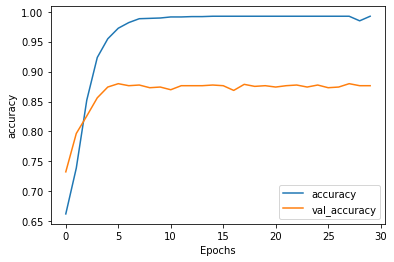

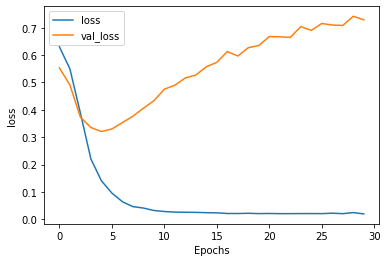

In [87]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [88]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '') for i in text])

print(decode_sentence(training_padded[0]))
print(training_reviews[2])
print(labels[2])

office clean staff friendly see timely manner nurse practitioner stephanie saw kind helpful answer listened concern answer question                                                                                  
doctor valenzuela amaze highly recommend make feel comfortable give honest feedback doctor past give run around not enough information mainly chino hill location entire staff friendly since day 1
1


In [89]:
sentence = [" "]
sequences = tokenizer.texts_to_sequences(sentence)
print(sequences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[85, 3]]
[[0.61636734]]


In [92]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
LABELS = ['negative', 'positive']

# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(pred, testing_labels, target_names=LABELS)
print(report)

              precision    recall  f1-score   support

    negative       0.74      0.79      0.76       222
    positive       0.93      0.91      0.92       668

    accuracy                           0.88       890
   macro avg       0.83      0.85      0.84       890
weighted avg       0.88      0.88      0.88       890



In [93]:
LABELS = ['negative', 'positive']
def get_prediction(review):
    # Preprocessing
    reviews = clean_review(review)
    review_np_array = tokenizer.texts_to_sequences([reviews])
    #print(reviews)
    review_np_array = pad_sequences(review_np_array, maxlen=100, padding="post", value=0)
    # Prediction
    score = model.predict(review_np_array)[0][0]
    prediction = LABELS[model.predict_classes(review_np_array)[0][0]]
    print('REVIEW:', review, '\nPREDICTION:', prediction)

In [98]:
get_prediction(""" Doctors are fine. Billing/Insurance staff is unprofessional and incompetent to a level that I have never experienced at any other medical office. Aside from lacking basic decency and common sense, I had to file a formal complaint as the staff violated numerous HIPAA laws. This place is a mess.""")

REVIEW:  Doctors are fine. Billing/Insurance staff is unprofessional and incompetent to a level that I have never experienced at any other medical office. Aside from lacking basic decency and common sense, I had to file a formal complaint as the staff violated numerous HIPAA laws. This place is a mess. 
PREDICTION: negative
